In [176]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch

from tqdm.notebook import tqdm

import pandas as pd
import os

from PIL import Image
import numpy as np

import timm

import matplotlib.pyplot as plt



In [177]:

dir = 'data\\gaussian_filtered_images\\gaussian_filtered_images'
train_list = 'data\\train.csv'
val_list = 'data\\val.csv'
test_list = 'data\\test.csv'

classi = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
    }

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [178]:
# dataset class

class EyeDataset(Dataset):
    def __init__(self,main_dir, transform= None):
        super(EyeDataset, self).__init__()
        self.list = main_dir
        self.image_list = self.get_image_dirs()
        self.lable_list = self.get_lables_list()
        self.tranform = transform

    def get_image_dirs(self):
        df = pd.read_csv(self.list)

        image_l = list()
        a = df['id_code']
        b = df['diagnosis']

        for i, j in zip(a,b):
            root = dir
            category = classi[j]
            img = str(i + '.png')
            loc = os.path.join(root, category, img)
            image_l.append(loc)
        
        return image_l

    def get_lables_list(self):
        df = pd.read_csv(self.list)
        return df['diagnosis'][:] 

    def __getitem__(self, index):
        
        a = self.image_list[index]
        b = self.lable_list[index]

        img = Image.open(a)
        img = self.tranform(img)
        
        return img,b

    def __len__(self):
        return len(self.lable_list)

In [179]:
# model class

class Classifer(nn.Module):
    def __init__(self, num_classes=5):
        super(Classifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [180]:
train_dataset = EyeDataset(train_list, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = EyeDataset(val_list, transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = EyeDataset(test_list, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [181]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Classifer(num_classes=5)
model.to(device)

Classifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [182]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [183]:
num_epochs = 7
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

t_labs = []
t_preds = []

v_labs = []
v_preds = []

In [184]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_acc = 0.0
    y_pred = []

    for images, labels in tqdm(train_loader, desc= 'Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

        y_pred = torch.argmax(outputs, dim=1)

        t_labs.append(labels)
        t_preds.append(y_pred)
    
        train_acc += torch.sum(y_pred == labels)

    train_accu = train_acc/len(train_loader.dataset) * 100
    train_accuracy.append(train_accu)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    val_acc = 0.0
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            y_pred = torch.argmax(outputs, dim=1)
            
            v_labs.append(labels)
            v_preds.append(y_pred)
        
            val_acc += torch.sum(y_pred == labels)

    val_accu = val_acc/len(val_loader.dataset) * 100
    val_accuracy.append(val_accu)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:0.6f},Train Acc: {train_accu:0.6f}, Validation loss: {val_loss:0.6f}, Validation Acc: {val_accu:0.6f}")

Training loop:   0%|          | 0/77 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/7 - Train loss: 0.796121,Train Acc: 71.689682, Validation loss: 0.785400, Validation Acc: 74.166664


Training loop:   0%|          | 0/77 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/7 - Train loss: 0.583617,Train Acc: 78.025993, Validation loss: 0.623259, Validation Acc: 79.000000


Training loop:   0%|          | 0/77 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/7 - Train loss: 0.471684,Train Acc: 83.468719, Validation loss: 0.580008, Validation Acc: 79.500000


Training loop:   0%|          | 0/77 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/7 - Train loss: 0.373578,Train Acc: 86.230705, Validation loss: 0.651904, Validation Acc: 79.500000


Training loop:   0%|          | 0/77 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/7 - Train loss: 0.296719,Train Acc: 89.358246, Validation loss: 1.117887, Validation Acc: 69.000000


Training loop:   0%|          | 0/77 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/7 - Train loss: 0.240603,Train Acc: 91.389114, Validation loss: 1.127380, Validation Acc: 73.000000


Training loop:   0%|          | 0/77 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7/7 - Train loss: 0.215571,Train Acc: 92.242081, Validation loss: 0.886835, Validation Acc: 77.166672


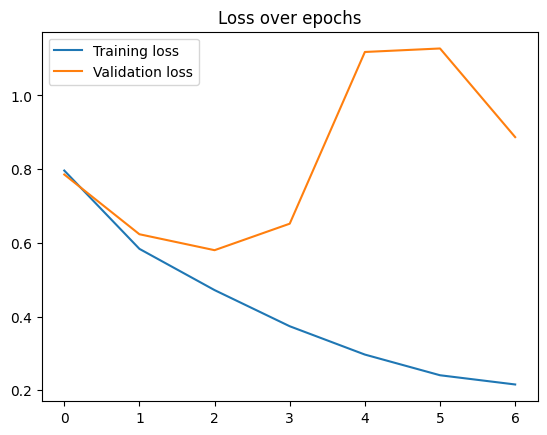

In [185]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

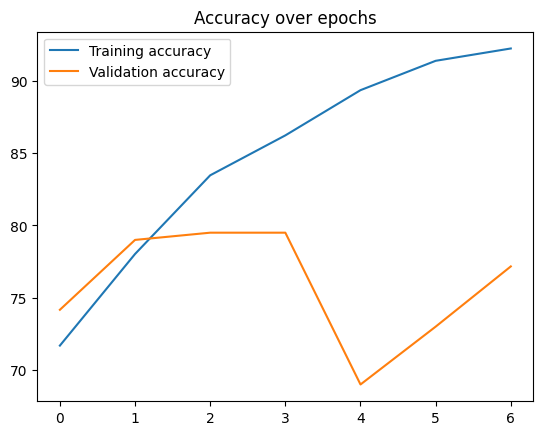

In [186]:
plt.plot(torch.tensor(train_accuracy).cpu(), label='Training accuracy')
plt.plot(torch.tensor(val_accuracy).cpu(), label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [187]:
test_accuracy = []
test_losses = []


# test phase
model.eval()
running_loss = 0.0
test_acc = 0.0
y_pred = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Test loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
     
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
        y_pred = torch.argmax(outputs, dim=1)
            
        v_labs.append(labels)
        v_preds.append(y_pred)
    
        test_acc += torch.sum(y_pred == labels)

test_accu = test_acc/len(test_loader.dataset) * 100
test_accuracy.append(test_accu)
test_loss = running_loss / len(test_loader.dataset)
test_losses.append(test_loss)
print(f"Test loss: {test_loss:0.6f}, Test Acc: {test_accu:0.6f}")

Test loop:   0%|          | 0/19 [00:00<?, ?it/s]

Test loss: 0.951577, Test Acc: 77.333336
